<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/MNIST_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building an Encoder-Decoder model with the MNIST dataset

#### Imports

In [2]:
import keras
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model

from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard

from PIL import Image
import matplotlib.pyplot as plt

#### Importing the MNIST data

The data comes in a tuple that contains two tuples, one with the training data and one with the test data. So we create two variables x_train / x_test that conatin the datasets for training and testing.

You can see below that the train set (which is the first tuple) has 60.000 images of 28x28, while the test set has 10.000 images of 28x28.

In [10]:
mnist.load_data()[0][0].shape, mnist.load_data()[1][0].shape

((60000, 28, 28), (10000, 28, 28))

Below we import the data as a numpy array and normalize it. The color matrix is normalized by dividing over 255. 

Then we perform a reshape on the X_train value to get a tensor of 60.000 matrices of 28x28x1 (the 1 is the "depth" of each matrix, since the image doesn't have RGB, it's just black & white).

In [11]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [12]:
x_train.shape

(60000, 28, 28, 1)

### Building the model

Below we build up the model of the autoencoder. An autoencoder is a type of model made up of two parts an "Encoder" that compresses the data into a vector space (takes a matrix and reduces it to a vector which is called an embedding).

Then a "Decoder" model is trained that learns to decompress the data from the vector space back to the image. We are interested in the encoder, but the decoder is very important because it is what links our embeddings to the actual images we are training the model with.

The vector space is often called a Latent vector space, so when you see a "latent_dim" variable it is referring to the dimension of the vector to which the images are compressed at the end of the "Encoder".

We need the model to be "separable" as we want the embeddings, so we will create a model for the encoder and a model for the decoder (which includes part of the encoder) so that we can split them. The full model will be called "autoencoder".

In [14]:
latent_dim = 128
input_img = keras.Input(shape=(28, 28, 1))

## Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

## Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 8)           584 

In [ ]:
#!tensorboard --logdir=/tmp/autoencoder

### Fitting the model

Something important to note here: Notice that the training and validation data are the same (we are training with X_train and X_train instead of the typical X_train and y_train). This is because in this type of problem, our input and output should be identical.

The model will be trained to output the same image that we feed it as input, and so our "targets" are the exact same images we give the model to train. The more similar they are, the better the model is getting at compressing the data into a vector space that the decoder can convert back to an image.

In [16]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 15s 8ms/step - loss: 0.2168 - val_loss: 0.1519
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1398 - val_loss: 0.1301
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1263 - val_loss: 0.1211
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1192 - val_loss: 0.1156
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1149 - val_loss: 0.1120
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1119 - val_loss: 0.1097
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1096 - val_loss: 0.1077
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1078 - val_loss: 0.1068
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1064 - val_loss: 0.1047
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1053 - val_loss: 0.104

### Testing the resulting model from end to end

Below we are going to pick 10 images of digits from our dataset and pass them through the model using the .predict() method. If the training went well, the images the model outputs should be very similar to the ones we feed it.

In the examples below, the images on top are the ones we feed to the model, and the images on bottom are the ones our model outputs. Notice that the quality is very good.

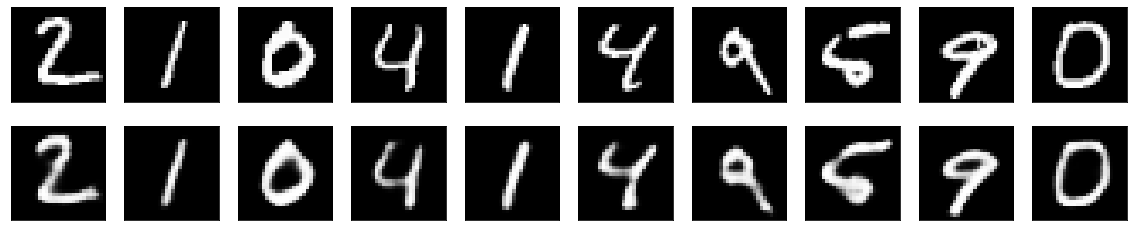

In [17]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let's try "adding" the vector space representations and see if they return something that makes sense. I think adding a 1 and a 0 should return a nine, but let's try it and see for ourselves.

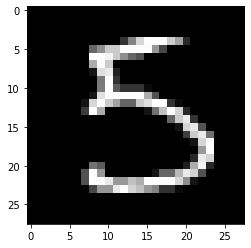

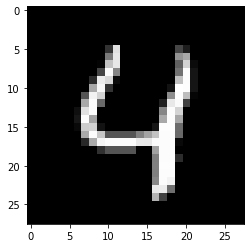

In [24]:
plt.imshow(x_test[15].reshape(28, 28))
plt.figure()
plt.imshow(x_test[4].reshape(28, 28))

In [25]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test[4:16])
encoded_imgs.shape  # The vector representations are 128 elements long so the vector output is 4 x 4 x 8, and there are 2 images so this is coherent

(12, 4, 4, 8)

Let's add the images together and see what the representation of the sum of the two vectors in the vector space represents in the tensor space of the image.

In [57]:
encoded_sum = (encoded_imgs[0] + encoded_imgs[11]) / 2
encoded_sum = encoded_sum.reshape(1, 4, 4, 8)

Now we extract the decoder layers from the autoencoder, so that we can 'decode' the vector representation obtained by calculating the sum of the two digits above. This doesn't always work, but in theory adding up two elements should perform an operation similar to merging both elements into one.

In [58]:
# Create decoder
latent_inputs = keras.Input(shape=(4,4,8,), name='z_sampling')

decoder = autoencoder.layers[-7](latent_inputs)
decoder = autoencoder.layers[-6](decoder)
decoder = autoencoder.layers[-5](decoder)
decoder = autoencoder.layers[-4](decoder)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)

decoder_model = Model(latent_inputs, decoder, name='decoder')

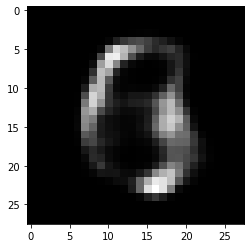

In [59]:
decoder_model.predict(encoded_sum).reshape(28, 28)
plt.imshow(decoder_model.predict(encoded_sum).reshape(28,28))

### Creating fading images from a number to the next

Below we are taking two images (a 4 and a 5) and making a fading image that moves through the values of the vector space in small intervals to get from one number to the next. Note that we are changing the vector representation of each number in small intervals (1/10 of the difference size) so that we can see the changes.

In [49]:
num_faded_images = 10

In [43]:
fading_vector = np.linspace(encoded_imgs[0], encoded_imgs[11], num_faded_images)
fading_vector.shape

(10, 4, 4, 8)

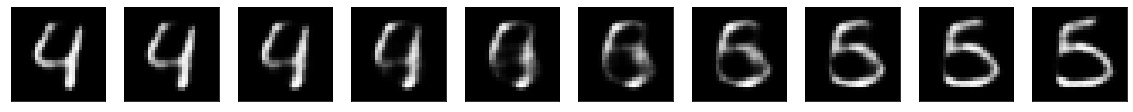

In [56]:
plt.figure(figsize=(20, 4))

for i in range(1, num_faded_images + 1):
    # Display original
    embedding = fading_vector[i - 1]
    image_array = decoder_model.predict(embedding.reshape(1, 4, 4, 8))
    ax = plt.subplot(1, num_faded_images, i)
    plt.imshow(image_array.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()